In [1]:
import os 
import json
import numpy as np
import pandas as pd
import keras
from keras.callbacks import Callback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [17]:
import os 
import cv2
import math

from PIL import Image
import matplotlib.pyplot as plt

In [5]:
os.getcwd()

'/home/zxt/test/iWildCam'

In [10]:
label_df = pd.read_csv('/home/zxt/test/iWildCam/train.csv')
submission_df = pd.read_csv('/home/zxt/test/iWildCam/sample_submission.csv')
label_df.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


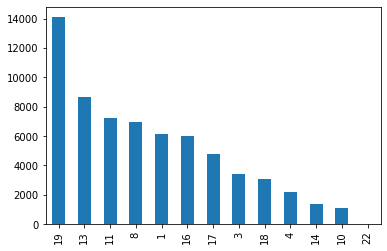

In [14]:
label_df['category_id'].value_counts()[1:16].plot(kind='bar')

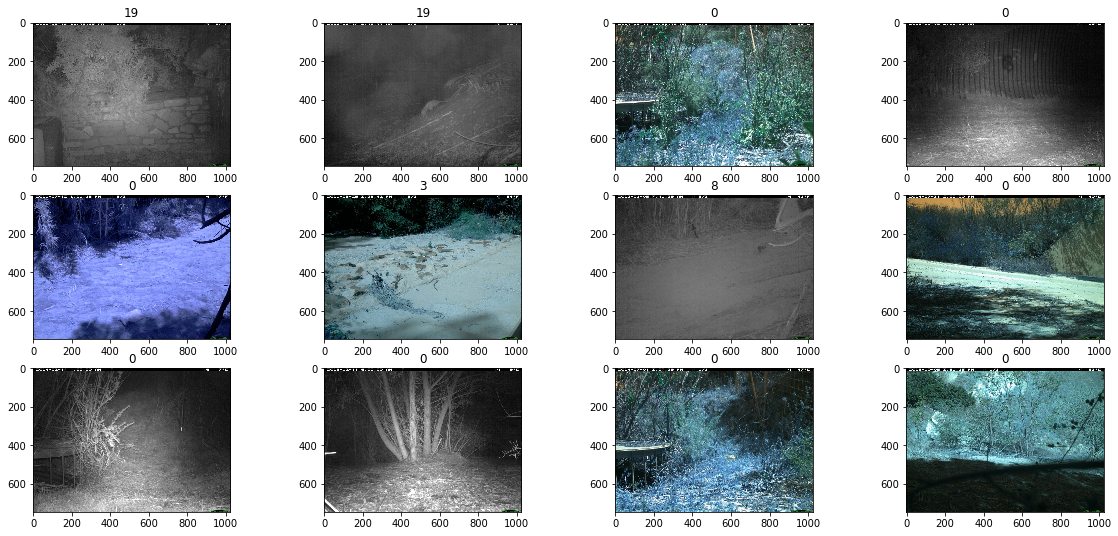

In [19]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 3*rows))
    
    for i in range(columns * rows):
        image_path = df.loc[i, 'file_name']
        image_id =df.loc[i,'category_id']
        img = cv2.imread(f'/home/zxt/test/iWildCam/train_images/{image_path}')
        fig.add_subplot(rows,columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
display_samples(label_df)

## Preprocessing



In [24]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff=new_shape - im.shape[0], new_shape-im.shape[1]
    t,b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l,r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b),(l,r),(0,0))
    else:
        pad_width = ((t,b),(l,r))
    return pad_width

def pad_and_resize(image_path, dataset, pad=False, desired_size=32):
    img=cv2.imread(f'/home/zxt/test/iWildCam/{dataset}_images/{image_path}.jpg')
    
    if pad:
        pad_width = get_pad_width(img, max(img.shape))
        padded = np.pad(img, pad_width=pad_width, mode='constant',constant_values=0)
    else:
        padded = img
        
    resized = cv2.resize(padded, (desired_size,)*2).astype('uint8')
    
    return resized
    
    

In [25]:
submission_df.head()

,Id,Predicted
0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0
1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,0
2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0
3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,0
4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,0


In [26]:
%%time
train_resized_imgs = []
test_resized_imgs = []

for image_id in label_df['id']:
    train_resized_imgs.append(
        pad_and_resize(image_id,'train')
    )
    
for image_id in submission_df['Id']:
    test_resized_imgs.append(
        pad_and_resize(image_id,'test')
    )

KeyboardInterrupt: 

In [27]:
X_train = np.stack(train_resized_imgs)
X_test = np.stack(test_resized_imgs)

target_dummies = pd.get_dummies(label_df['category_id'])
train_label = target_dummies.columns.values
y_train = target_dummies.values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)


ValueError: need at least one array to stack

In [ ]:
np.save('X_train.npy',X_train)
np.save('X_test.npy',X_test)
np.save('y_train.npy',y_train)